# Hypothesis 3 : the genre influences the ratings 

Loading dataset and remove lines without genres:

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import pymongo

In [8]:
# Connect to MongoDB and select the database 
mongo = pymongo.MongoClient()
mongo_db = mongo.project
# Load the reviews from the reviews collection 
data = pd.DataFrame(list(mongo_db.reviews.find({}, {'_id': False})))
#Close the connection
mongo.close() 
print(data.shape)
# Change the label of a specific field (column)
data.rename(columns={'genre': 'genres'}, inplace=True)

data = data[~data['genres'].str.contains('-')]

data = data[~data['genres'].str.contains('(no genres listed)', regex=False)]
data['rating'] = data['rating'].astype(float)
print(data.shape)



(300639, 11)
(44704, 11)


Split the genre field by the "|" character and expand into multiple columns

(44704, 18)
        rating variable     genre
0         10.0  genre_0    Comedy
2          8.0  genre_0     Drama
3          6.0  genre_0    Comedy
4          8.0  genre_0    Horror
5          5.0  genre_0     Crime
...        ...      ...       ...
300899     7.0  genre_6  Thriller
300900     3.0  genre_6  Thriller
300901     8.0  genre_6  Thriller
300902     5.0  genre_6  Thriller
300903     6.0  genre_6  Thriller

[86023 rows x 3 columns]
['Comedy' 'Drama' 'Horror' 'Crime' 'Action' 'Adventure' 'Thriller'
 'Documentary' 'Children' 'Mystery' 'Animation' 'Western' 'Musical' 'War'
 'Fantasy' 'Romance' 'IMAX']
(86023, 3)
          genre  avg_rating
0        Action    6.607789
1     Adventure    6.736222
2     Animation    7.451550
3      Children    7.284363
4        Comedy    6.906832
5         Crime    6.994051
6   Documentary    7.494662
7         Drama    7.142565
8       Fantasy    6.744499
9        Horror    6.201473
10         IMAX    6.450292
11      Musical    7.238443
12      M

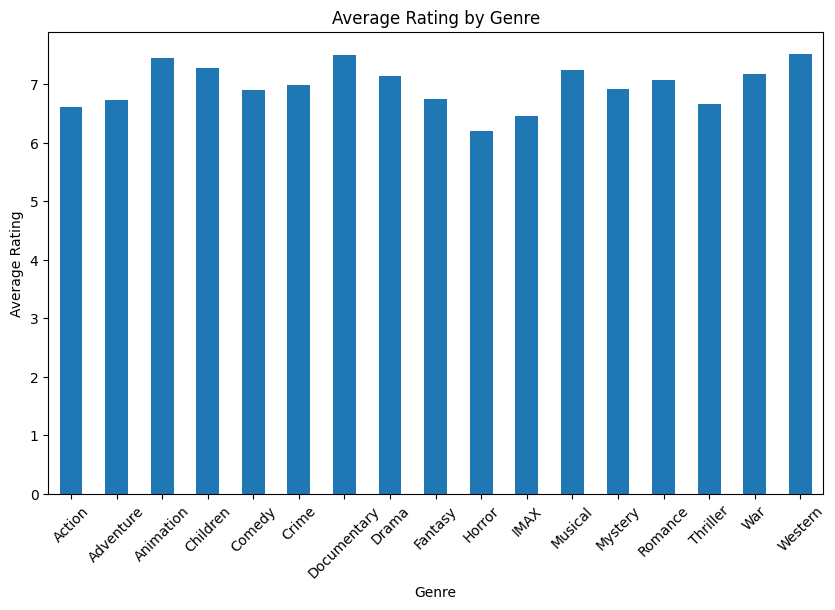

In [9]:
# Split the genre field by the "|" character and expand into multiple columns
split_genres = data['genres'].str.split('|', expand=True)


# Add the split genre columns to the original DataFrame
data = pd.concat([data, split_genres], axis=1)


# Rename the split genre columns
genre_columns = [f'genre_{i}' for i in range(split_genres.shape[1])]
data.columns = list(data.columns[:-split_genres.shape[1]]) + genre_columns

print(data.shape)


# Convert the genre-specific columns to a single 'genre' column using melt
melted_data = pd.melt(data, id_vars=['rating'], value_vars=genre_columns, value_name='genre').dropna()
# Assuming your dataset is stored in a DataFrame called 'df'
column_name = 'genre'  # Replace 'ColumnName' with the actual name of your column

# Get unique values in the column
unique_values = melted_data[column_name].unique()

#Print dataset with rating for each review and genre
print(melted_data)

# Print the unique values
print(unique_values)

print(melted_data.shape)

# Calculate the mean rating for each genre
mean_ratings = melted_data.groupby('genre')['rating'].mean()

# Convert mean_ratings to a DataFrame with 'genre' and 'avg_rating' columns
avg_rating_data = mean_ratings.reset_index(name='avg_rating')

# Print the dataset with genre and average rating columns
print(avg_rating_data)


# Create a bar plot
plt.figure(figsize=(10, 6))
mean_ratings.plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.title('Average Rating by Genre')
plt.xticks(rotation=45)
plt.show()

## ANOVA TEST
ANOVA compares the means of multiple groups to determine if there are significant differences among them. 
In this case, the groups are the different genres, and the ratings are the variable of interest.

In [10]:
# Group the ratings by genre
grouped_data = melted_data.groupby('genre')['rating']

# Extract the ratings for each genre
genre_ratings = [grouped_data.get_group(genre) for genre in unique_values]

# Perform ANOVA
statistic, p_value = f_oneway(*genre_ratings)

# Print the results
print("ANOVA results:")
print("F-statistic:", statistic)
print("p-value:", p_value)

ANOVA results:
F-statistic: 52.32108488265924
p-value: 5.308812512268863e-167


The results of the ANOVA test indicate a highly significant effect of genre on ratings. 
- F-statistic (52.32) : it suggests that there is a substantial difference in ratings among the different genres. 
- P-value (5.30e-167): it provides strong evidence against the null hypothesis, indicating that the observed differences in ratings are unlikely to have occurred by chance alone.

Overall, these results highlight the importance of genre in shaping audience perceptions and preferences when it comes to movie ratings.

# Hypothesis 4 : the genre influences popularity (a combination of rating + number of reviews) 

In [11]:
# for each genre count the occurrences
genre_counts = melted_data['genre'].value_counts()

# Convert genre_counts to a DataFrame with 'genre' and 'counts' columns
counts_data = genre_counts.reset_index()
counts_data.columns = ['genre', 'counts']

# Print the dataset with genre and counts columns
print(counts_data)

# Merge the two DataFrames based on the genre column
merged_data = pd.merge(avg_rating_data, counts_data, on='genre')

# Print the merged data
print(merged_data)

          genre  counts
0         Drama   18567
1        Comedy   12354
2      Thriller    9597
3        Action    7960
4       Romance    7104
5         Crime    5883
6     Adventure    5008
7        Horror    4482
8       Fantasy    3272
9       Mystery    2867
10          War    2337
11      Musical    1644
12     Children    1586
13    Animation    1032
14  Documentary     843
15      Western     803
16         IMAX     684
          genre  avg_rating  counts
0        Action    6.607789    7960
1     Adventure    6.736222    5008
2     Animation    7.451550    1032
3      Children    7.284363    1586
4        Comedy    6.906832   12354
5         Crime    6.994051    5883
6   Documentary    7.494662     843
7         Drama    7.142565   18567
8       Fantasy    6.744499    3272
9        Horror    6.201473    4482
10         IMAX    6.450292     684
11      Musical    7.238443    1644
12      Mystery    6.913847    2867
13      Romance    7.068834    7104
14     Thriller    6.659373 

Analyze if genre influences popularity (plot)

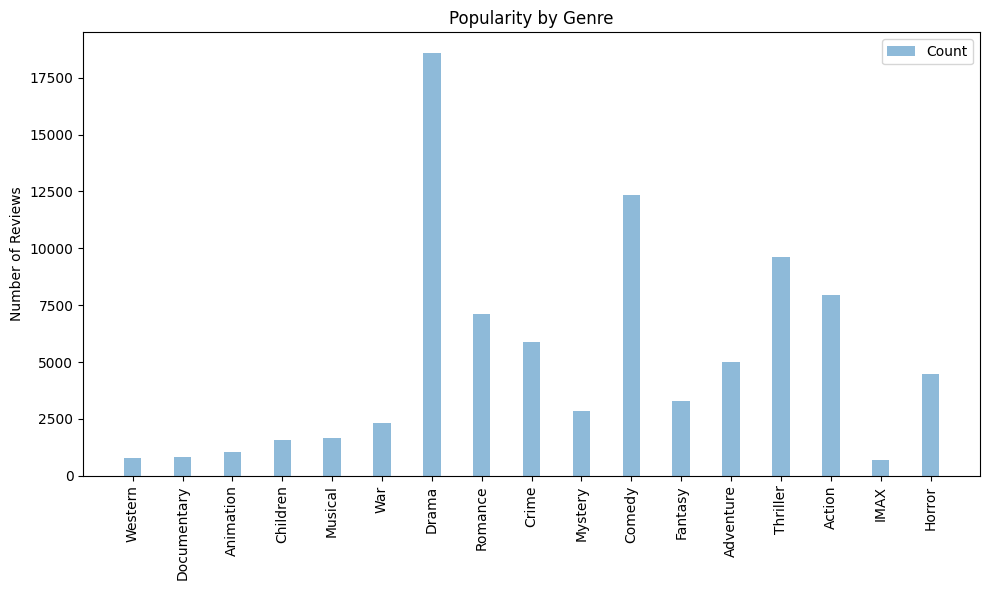

In [12]:
# Sort the dataset by average rating in descending order
sorted_data = merged_data.sort_values('avg_rating', ascending=False)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar chart
bar_width = 0.35
index = range(len(sorted_data))
bar2 = ax.bar(index, sorted_data['counts'], bar_width, label='Count', alpha=0.5)

# Set the x-axis labels and tick labels
ax.set_xticks(index)
ax.set_xticklabels(sorted_data['genre'], rotation=90)

# Set the y-axis label
ax.set_ylabel('Number of Reviews')

# Set the title
ax.set_title('Popularity by Genre')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show() 

Correlation coefficient between the average rating and the count columns and determine the strength and direction of the relationship, using either the Pearson correlation or the Spearman correlation

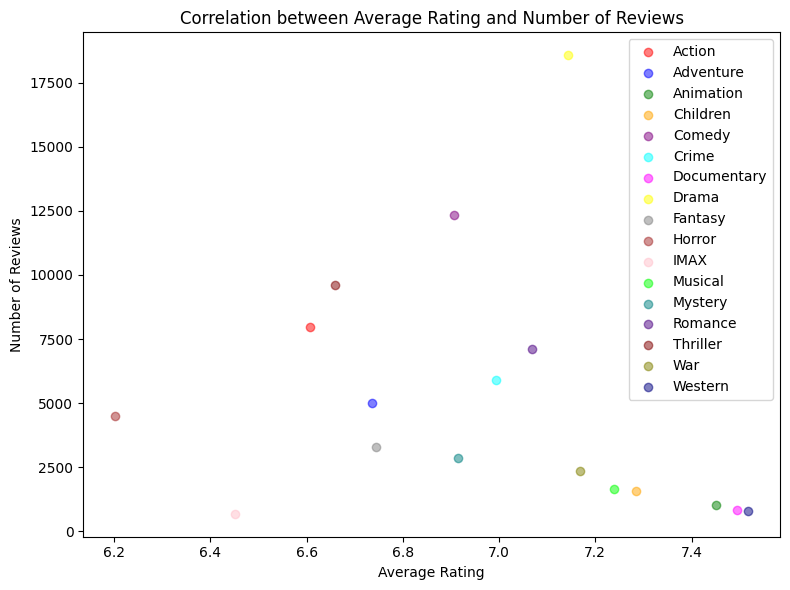

In [13]:
# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Define a list of colors for each genre
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'gray', 'brown',
          'pink', 'lime', 'teal', 'indigo', 'maroon', 'olive', 'navy', 'sienna']

# Iterate through each genre and plot the corresponding points with a unique color
for i, genre in enumerate(merged_data['genre'].unique()):
    genre_data = merged_data[merged_data['genre'] == genre]
    ax.scatter(genre_data['avg_rating'], genre_data['counts'], color=colors[i], alpha=0.5, label=genre)

# Set the x-axis label
ax.set_xlabel('Average Rating')

# Set the y-axis label
ax.set_ylabel('Number of Reviews')

# Set the title
ax.set_title('Correlation between Average Rating and Number of Reviews')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [14]:
from scipy.stats import pearsonr

# Assuming you have the dataset with three columns: 'genre', 'avg_rating', and 'counts'
# stored in a DataFrame called 'merged_data'

# Extract the average rating and number of reviews for each genre
avg_rating = merged_data['avg_rating']
review_counts = merged_data['counts']

# Perform correlation analysis
correlation, p_value = pearsonr(avg_rating, review_counts)

# Print the results
print("Correlation analysis results:")
print("Correlation coefficient:", correlation)
print("p-value:", p_value)


Correlation analysis results:
Correlation coefficient: -0.20975047724244555
p-value: 0.41909166914624535


- Correlation coefficient (-0.209) : it suggests a moderate negative correlation between the average rating and the number of reviews for each genre. This means that as the average rating increases, the number of reviews tends to decrease, and vice versa. However, the magnitude of the correlation is not particularly strong.
- P- value (0.419) : it indicates the statistical significance of the correlation coefficient

Therefore, we cannot conclude with confidence that there is a significant correlation between the average rating and the number of reviews for each genre. The result suggests that there may not be a substantial influence of genre on the popularity based on the combination of rating and number of reviews.

# Bubble plot


/var/folders/nz/4vmkthvs5t96x_lskld0wc8r0000gn/T/ipykernel_26418/2862491295.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  dummy_scatter = ax.scatter([], [], label=genre, c=color)
/var/folders/nz/4vmkthvs5t96x_lskld0wc8r0000gn/T/ipykernel_26418/2862491295.py:37: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


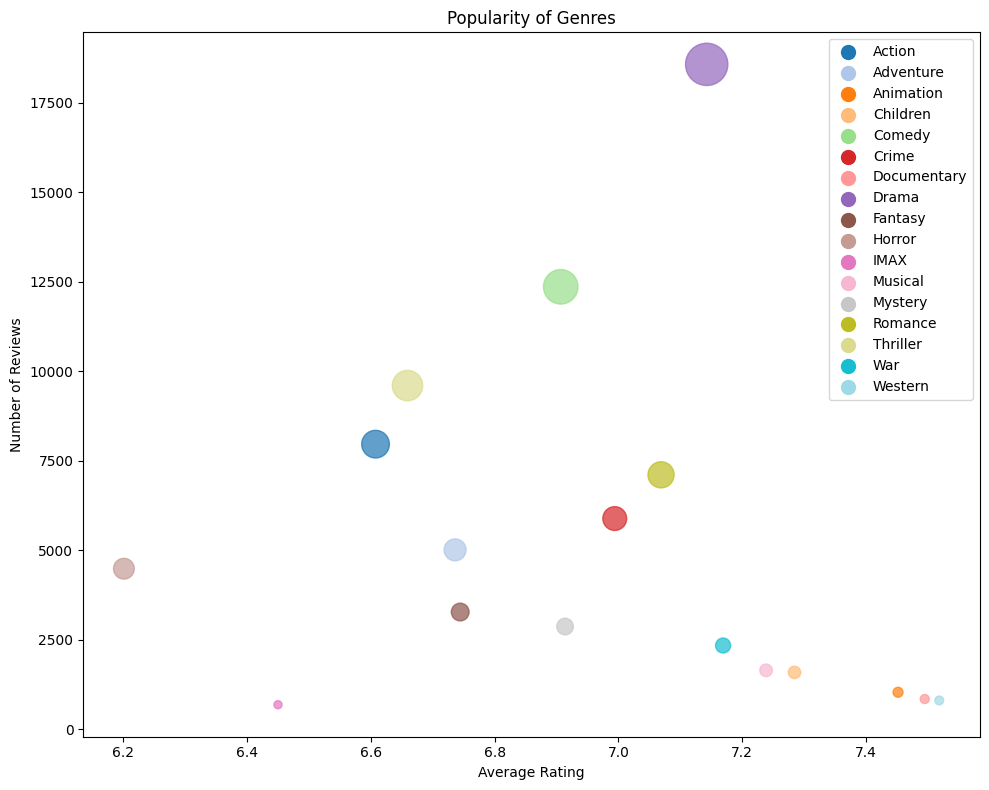

In [15]:
import numpy as np

# Assuming you have the dataset with three columns: 'genre', 'avg_rating', and 'counts'
# stored in a DataFrame called 'merged_data'

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Define marker size based on the number of reviews
marker_size = merged_data['counts']/20

# Define a list of colors for each genre
colors = plt.cm.tab20(np.linspace(0, 1, len(merged_data['genre'].unique())))

# Create the bubble plot with genre-specific colors
scatter = ax.scatter(merged_data['avg_rating'], merged_data['counts'], s=marker_size, alpha=0.7, c=colors)

# Create dummy scatter plots for the legend
legend_handles = []
for genre, color in zip(merged_data['genre'].unique(), colors):
    dummy_scatter = ax.scatter([], [], label=genre, c=color)
    legend_handles.append(dummy_scatter)

# Set the x-axis label
ax.set_xlabel('Average Rating')

# Set the y-axis label
ax.set_ylabel('Number of Reviews')

# Set the title
ax.set_title('Popularity of Genres')

# Add a legend with genre labels and colors
legend = ax.legend(handles=legend_handles, loc='upper right')

# Set the marker size in the legend
for handle in legend.legendHandles:
    handle.set_sizes([100])

# Show the plot
plt.tight_layout()
plt.show()

